In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from dataloader_2 import make_dataloaders

In [8]:
os.getcwd()
[3.]==3

False

In [4]:
train_path = '/zhome/27/c/138037/share/data/train/'
test_path = '/zhome/27/c/138037/share/data/test/'
classes = {'Barley':0, 'Broken':1, 'Oat':2, 'Rye':3, 'Wheat':4}
barley_dim = np.load(os.getcwd() + '/barley_dim.npy')
broken_dim = np.load(os.getcwd() + '/broken_dim.npy')
oat_dim = np.load(os.getcwd() + '/oat_dim.npy')
rye_dim = np.load(os.getcwd() + '/rye_dim.npy')
wheat_dim = np.load(os.getcwd() + '/wheat_dim.npy')
dim_means = [np.mean(barley_dim[1:], axis=0), np.mean(broken_dim[1:], axis=0), np.mean(oat_dim[1:], axis=0), np.mean(rye_dim[1:], axis=0), np.mean(wheat_dim[1:], axis=0)]
#Define hyperparameters and model
# model_choice = "ConvNet" #"SE_ResNet" "ResNet" "ConvNet"
batch_size = 1
broken_dim.shape


(900, 2)

In [3]:
train_loader,test_loader = make_dataloaders(batch_size=64,transform=True)

test = np.zeros(13).reshape(1,13)
for data in test_loader:
    test = np.append(test, data, axis=0)
    
train = np.zeros(13).reshape(1,13)
for data in train_loader:
    train = np.append(train, data, axis=0)

np.save('test_featuredata.npy', test)
np.save('train_featuredata.npy', train)

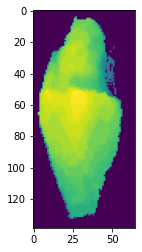

In [380]:
plt.imshow(image[:,:,6])
plt.show()


In [375]:
print(np.mean(image[mask == 1], axis=0)[:7])

print(np.mean(image[mask == 1], axis=0)[:7] / np.array([1, 0.94901961, 0.96078432, 0.99215686, 0.99607843, 1, 0.59215689]))


[ 24.26163283  60.17724196  78.07254653  98.9323181  114.7605753
 192.46594755  29.27622673]
[ 24.26163283  63.40990358  81.25918055  99.71439204 115.21238874
 192.46594755  49.43998327]


167


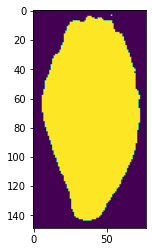

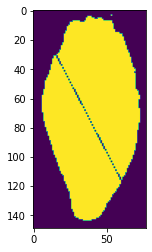

60


In [50]:
#Developmenting
path = '/zhome/27/c/138037/share/data/train/'
classes = {'Wheat':0} # 'Broken':1, 'Oat':2, 'Rye':3, 'Wheat':4}
def masker(image):
    #create a simple mask, and make everything else 0
    mask = np.zeros((image.shape[0],image.shape[1]))
    temp_blue = image[:,:,1].copy()
    temp_blue[temp_blue==0] = 1
    mask[image[:,:,4]/temp_blue >= 1] = 1
    mask[image[:,:,4] >= 40] = 1
    mask[:5,:5] = 0
    image[mask==0] = 0
    return image, mask

img1 = image
image, mask = masker(np.load(os.path.join(path + 'Barley' + '/' + next(os.walk(path  + 'Barley'))[2][350])))
temp = np.sqrt(mask.shape[0]**2 + mask.shape[1]**2)
print(int(temp))
img2 = mask.copy()
plt.imshow(mask)
plt.show()

eye = np.eye(int(temp))
img3 = eye.copy()
diag = cv2.resize(eye, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_LANCZOS4)
l = len(np.ma.masked_greater(diag, 0))
mean = np.mean(np.ma.where(diag)) / l

img4 = diag.copy()
diag[np.ma.masked_greater_equal(diag, mean).mask] = 1
diag[np.ma.masked_less(diag, mean).mask] = 0

img5 = diag.copy()

diag[mask == 0] = 0
mask[diag == 1] = 0

img6 = diag
img7 = mask
plt.imshow(mask)
plt.show()
print(len(diag[diag == 1]))

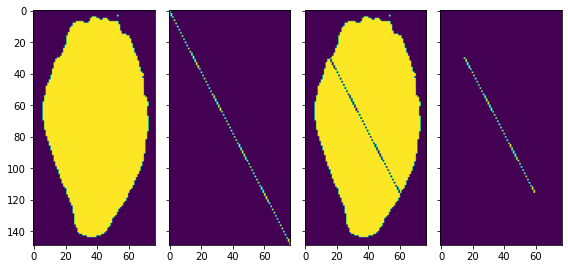

In [72]:
fig, axes = plt.subplots(1,4, figsize=(8,5), sharey=True, tight_layout=True)
axes[0].imshow(img2)
axes[1].imshow(img5)
axes[2].imshow(img7)
axes[3].imshow(img6)


plt.savefig('../img/feature_diag.png')

In [68]:
os.getcwd()

'/zhome/27/c/138037/share/src'

In [51]:
path = os.path.join(cwd, os.listdir(cwd)[10000])
image = np.load(path)

In [13]:
scaled_image = imgscaler(image, 256,128)
scaled_img, scaled_mask = masker(scaled_image)
img, mask = masker(image)
plt.imshow(img[:,:,[4,2,1]])
plt.show()
print(np.where(mask == 1))

#plt.imshow(scaled_img[:,:,[4,2,1]])
#plt.show()
#print(np.where(scaled_mask == 1))

NameError: name 'imgscaler' is not defined

In [323]:
path = '/zhome/27/c/138037/share/data/train/'
classes = {'Barley':0, 'Broken':1, 'Oat':2, 'Rye':3, 'Wheat':4}

# init feature extraction dataset samples = 66000, height, width, average-channel-intensity, mask-size, class
broken_dim = np.zeros(2).reshape(1,2)
barley_dim = np.zeros(2).reshape(1,2)
oat_dim = np.zeros(2).reshape(1,2)
rye_dim = np.zeros(2).reshape(1,2)
wheat_dim = np.zeros(2).reshape(1,2)

for category in list(classes.keys()):
    #print(category)
    file_paths = next(os.walk(path  + category))[2]
    i = 0
    for file in file_paths:
        #print(file)
        image, mask = masker(np.load(os.path.join(path + category + '/' + file)))
        min_x = np.min(np.where(mask)[1])
        max_x = np.max(np.where(mask)[1])
        min_y = np.min(np.where(mask)[0])
        max_y = np.max(np.where(mask)[0])
        height = max_y-min_y
        width = max_x-min_x
        size = image.shape
        
        if category == 'Broken':
            broken_dim = np.append(broken_dim, [[height,width]], axis=0)
            
        if category == 'Barley':
            barley_dim = np.append(barley_dim, [[height,width]], axis=0)
            
        if category == 'Oat':
            oat_dim = np.append(oat_dim, [[height,width]], axis=0)
            
        if category == 'Rye':
            rye_dim = np.append(rye_dim, [[height,width]], axis=0)
            
        if category == 'Wheat':
            wheat_dim = np.append(wheat_dim, [[height,width]], axis=0)

KeyboardInterrupt: 

In [27]:

print(f' Broken \n {np.mean(broken_dim[1:], axis=0)} \n Barley \n {np.mean(barley_dim[1:], axis=0)} \n Oat \n {np.mean(oat_dim[1:], axis=0)} \n Rye \n {np.mean(rye_dim[1:], axis=0)} \n Wheat \n {np.mean(wheat_dim[1:], axis=0)}')


 Broken 
 [78.55555556 56.17222222] 
 Barley 
 [144.0567037   61.16277778] 
 Oat 
 [162.74748148  49.79607407] 
 Rye 
 [117.61753086  41.89530864] 
 Wheat 
 [110.98353535  58.06888889]


In [33]:
np.save('broken_dim.npy', broken_dim[1:])
np.save('barley_dim.npy', barley_dim[1:])
np.save('oat_dim.npy', oat_dim[1:])
np.save('rye_dim.npy', rye_dim[1:])
np.save('wheat_dim.npy', wheat_dim[1:])

(13501, 2)

(27001, 2)

In [12]:
len(range(10))

10